total num of generated clusters = 200
set maxx in param.py = 27 X primcell_a
set maxy in param.py = 27 X primcell_b


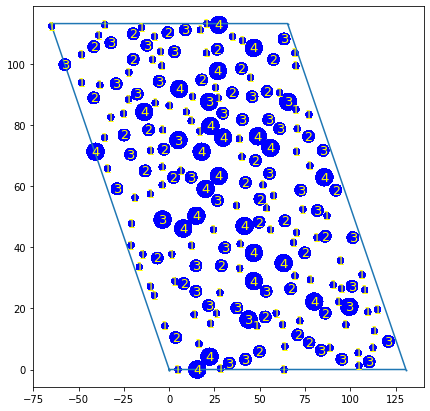

In [3]:
#!/usr/bin/env python

import numpy as np
import param, math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import LinearLocator
from matplotlib.ticker import ScalarFormatter


def distance(x1, y1, x2, y2):
    d = ((x1 - x2)**2.0 + (y1 - y2)**2.0)**(0.5)
    return d

numprimcell   = param.numprimecellFactor*param.num_clust + param.num_single_atom
xdups = ydups = (int(numprimcell**0.5) + 2)
PES           = [] # potential energy surface element, x, y, z, E
Clusters      = [] # all possible cluster R and E
N_mesh        = param.N_mesh # total number of PES points
N_meshx       = N_meshy = (N_mesh)**(0.5) # number of mesh points in x and y direction

if (param.num_clust == 0 and param.largest_cluster > 1):
    raise ValueError('Largest cluster must be 1 atom! set num_clust > 0')

with open('PES','r') as f1:
    data = f1.readlines()
    for line in data:   
        PES.append([ str(line.split()[0]), 
                     float(line.split()[1]), 
                     float(line.split()[2]), 
                     float(line.split()[3]) ])
with open('INIT', 'w') as f2:
    f2.write('%3s  %10s  %16s  %15s  %14s\n' % ('Pt', 'R', 'X', 'Y', 'E'))

with open('DATA','r') as f3:
    f3.readline()
    data = f3.readlines()
    for line in data:  
        Clusters.append([ int(line.split()[0]), 
                         float(line.split()[1]), 
                         float(line.split()[2]), 
                         float(line.split()[3]),
                         float(line.split()[4]) ])   

np.random.seed()  # seed for random number generator
count = 0
counter = 0
coords = []
LCG = 0 # LCG is largest cluster radius

while (count < param.num_clust):
    if (param.largest_cluster == 2):
        temp = np.random.randint(0, 8)
    elif (param.largest_cluster == 3):
        temp = np.random.randint(0, 20)
    elif (param.largest_cluster == 4):
        temp = np.random.randint(0, 26)
    elif (param.largest_cluster == 5):
        temp = np.random.randint(0, 45)
    elif (param.largest_cluster == 6):
        temp = np.random.randint(0, 49)
    elif (param.largest_cluster == 7):
        temp = np.random.randint(0, 60)
    elif (param.largest_cluster == 8):
        temp = np.random.randint(0, 63)
    elif (param.largest_cluster > 8):
        temp = np.random.randint(0, param.largest_cluste + 55)
      
    # old method, not as accurate as using the PES data directly
    #x_normal = param.xstep_max * np.random.randint(0, (N_meshx - 1) * (xdups + 1)) 
    #y_normal = param.ystep_max * np.random.randint(0, (N_meshy - 1) * (ydups + 1)) 
    #y = y_normal * np.sin(np.deg2rad(60))
    #x = x_normal - y_normal * np.cos(np.deg2rad(60))
    
    # new method, using the PES data directly
    temp2 = np.random.randint(0, len(PES))
    yIncreaseFactor =  param.primcell_b * np.random.randint(0, ydups+1)
    y = PES[temp][2] + yIncreaseFactor * np.sqrt(3)/2
    x = PES[temp][1] + param.primcell_a * np.random.randint(0, xdups +1) -  yIncreaseFactor* 1 /2
    
    E = Clusters[temp][4]
    
    overlap = False
    
    for i in range(len(coords)):
        if (distance(x, y, coords[i][0], coords[i][1]) <= coords[i][2] + Clusters[temp][1] ):
            overlap = True # overlaping atoms

    # boundary overlap case check
    #if overlap == False:
        #overlap = boundaryOverlapCheck(coords, x, y, Clusters[temp][1], LCG)

    if (overlap == False):
        if LCG <= Clusters[temp][1]:
            LCG = Clusters[temp][1] 
        coords.append([x, y, Clusters[temp][1], Clusters[temp][0]])
        with open('INIT', 'a') as f2:
            f2.write('%3i %16.8f %16.8f %16.8f %16.8f \n' %  
                    (Clusters[temp][0], Clusters[temp][1], x, y, E))
        count += 1
    if (counter > param.CounterLimit):
        print('total num of generated clusters =', count)
        raise ValueError('small cell is used! use a larger cell!')
    counter += 1

count = 0
counter = 0
while (count < param.num_single_atom):
    temp = np.random.randint(0, len(PES))
    yIncreaseFactor =  param.primcell_b * np.random.randint(0, ydups+1) # numpy.random is exclusive on the 2nd slot
    y = PES[temp][2] + yIncreaseFactor * np.sqrt(3)/2 # if using random directly, it is inclusive on both slots
    x = PES[temp][1] + param.primcell_a * np.random.randint(0, xdups+1) -  yIncreaseFactor* 1 /2
    E = PES[temp][3]
    overlap = False
    for i in range(len(coords)):
        if (distance(x, y, coords[i][0], coords[i][1]) <= coords[i][2] +  param.Ratom):
            overlap = True # overlaping atoms
            
    # boundary overlap case check
    #if overlap == False:
        #overlap = boundaryOverlapCheck(coords, x, y, param.Ratom, LCG)

    if (overlap == False):
        if LCG <= Clusters[temp][1]:
            LCG = Clusters[temp][1]
        coords.append([x, y, param.Ratom, 1])
        with open('INIT', 'a') as f2:
            f2.write('%3i %16.8f %16.8f %16.8f %16.8f \n' %
                    (1, param.Ratom, x, y, E))
        count += 1
    if (counter > param.CounterLimit):
        print('total num of generated single atoms =', count)
        raise ValueError('small cell is used! use a larger cell!')
    counter += 1

if (counter <= param.CounterLimit):
    print('total num of generated clusters =', param.num_clust + param.num_single_atom)
    print('set maxx in param.py =', (xdups+1), 'X', 'primcell_a')
    print('set maxy in param.py =', (ydups+1), 'X', 'primcell_b')

    # plot setting

    #minorLocator = AutoMinorLocator()
    #mlx  = MultipleLocator(param.xstep_max)
    #mly  = MultipleLocator(param.ystep_max)

    #title_font = {'fontname':'Times New Roman', 'size':'18', 'color':'black', 'weight':'normal', 'verticalalignment':'bottom'} # Bottom vertical alignment for more space
    #axis_font = {'fontname':'Times New Roman', 'size':'18'}
    #mpl.rc('font',family='Times New Roman')

    #ax = plt.subplot() # Defines ax variable by creating an empty plot

    # Set the tick labels font
    #for label in (ax.get_yticklabels() + ax.get_xticklabels()):
        #label.set_fontname('Times New Roman')
        #label.set_fontsize(16)

    #ax.yaxis.set_minor_locator(mly)
    #ax.xaxis.set_minor_locator(mlx)

    xcoords = []
    ycoords = []
    Rcoords = []
    types   = []
    for i in range(len(coords)):
        xcoords.append(coords[i][0])
        ycoords.append(coords[i][1])
        Rcoords.append(30*int(coords[i][2])**2)
        types.append(int(coords[i][3]))

    #frame1 = plt.gca()
    #frame1.axes.yaxis.set_ticklabels([])
    #plt.yticks([])
    #frame1.axes.xaxis.set_ticklabels([])
    #plt.xticks([])
    #plt.ylim(0, param.maxy)
    #plt.xlim(- param.maxy / np.sqrt(3) , param.maxx)
    
    plt.figure(figsize=(7,7))
    boundaryDots_X = [0, param.maxx, param.maxx - param.maxy / np.sqrt(3), - param.maxy / np.sqrt(3), 0 ]
    boundaryDots_Y = [0, 0, param.maxy, param.maxy, 0]
    plt.plot(boundaryDots_X, boundaryDots_Y,marker="o", markerfacecolor="none", ms=1)
    
    for i,type in enumerate(types):
        x = xcoords[i]
        y = ycoords[i]
        plt.scatter(xcoords, ycoords, color='blue', s=Rcoords, marker='o')
        plt.text(x, y, type, fontsize=(12+type/3), color='yellow', horizontalalignment='center', 
                 verticalalignment='center')
    #plt.axvline(x=(xdups+1)*param.primcell_a, color='black', linestyle='-')
    #plt.axhline(y=(ydups+1)*param.primcell_b, color='black', linestyle='-')
    #plt.grid(which='minor', axis='both', linestyle='--')
    plt.show()



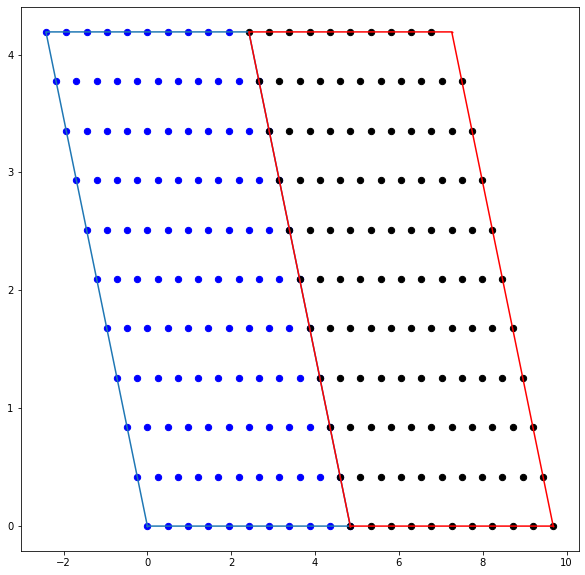

In [4]:
# test for PES file

plt.figure(figsize=(10,10))
boundaryDots_X = [0, param.primcell_a, param.primcell_a - param.primcell_b / 2, - param.primcell_b / 2, 0 ]
boundaryDots_Y = [0, 0, param.primcell_b* np.sqrt(3)/2, param.primcell_b* np.sqrt(3)/2, 0]
plt.plot(boundaryDots_X, boundaryDots_Y,marker="o", markerfacecolor="none", ms=1)

xPES = []
yPES = []
with open('PES','r') as f1:
    data = f1.readlines()
    for line in data:
        xPES.append(float(line.split()[1]))
        yPES.append(float(line.split()[2]))
        
plt.scatter(xPES, yPES, color='blue', s= 40, marker='o')


boundaryDots_X2 = [0 + param.primcell_a, param.primcell_a  + param.primcell_a, param.primcell_a - param.primcell_b / 2  + param.primcell_a, - param.primcell_b / 2  + param.primcell_a, 0   + param.primcell_a]
boundaryDots_Y2 = [0, 0, param.primcell_b* np.sqrt(3)/2, param.primcell_b* np.sqrt(3)/2, 0]
plt.plot(boundaryDots_X2, boundaryDots_Y2,marker="o", color = 'r', markerfacecolor="none", ms=1)

xPES = []
yPES = []
with open('PES','r') as f1:
    data = f1.readlines()
    for line in data:
        xPES.append(float(line.split()[1])+ param.primcell_a)
        yPES.append(float(line.split()[2]))
        
plt.scatter(xPES, yPES, color='black', s= 40, marker='o')

plt.show()

In [9]:
for i in range(100):
    print(np.random.randint(0, 2))

1
0
1
1
0
0
0
1
0
1
1
0
0
1
1
1
0
1
0
0
1
1
1
0
1
0
0
0
0
1
1
1
1
0
1
0
1
1
0
1
0
0
0
0
1
1
1
1
0
1
0
1
0
0
0
1
0
1
0
1
0
0
1
1
1
1
1
1
0
0
1
1
1
0
0
0
0
1
1
1
0
1
0
1
1
0
0
0
1
1
0
1
1
0
0
0
0
1
1
0
